# Site-specific Training of Neural Receivers

This notebook shows how the neural receiver can be [finetuned for a specific radio environment](https://developer.nvidia.com/blog/towards-environment-specific-base-stations-ai-ml-driven-neural-5g-nr-multi-user-mimo-receiver/).

An interesting aspect of machine learning (ML)-based
receiver design is the inherent possibility for data-aided fine-tuning and site-specific adaptation of the algorithms. Contrary
to (accidental) overfitting of the NN, the idea is to let the
receiver learn the underlying channel statistics of the site-specific deployment scenario.
A promising feature of neural receivers is that they can adapt to a specific dataset that inherently captures all real-world effects and the underlying channel statistics. As such, we envision AI/ML-driven basestation algorithms that collect data in the field and improve their performance even after deployment.

We recommend this [tutorial notebook](tutorial.ipynb) as jump-start to the training framework.
We also recommend the [Introduction to Sionna Ray Tracing](https://nvlabs.github.io/sionna/examples/Sionna_Ray_Tracing_Introduction.html) for further details about ray tracing and its implementation in Sionna [3](#references).

## Table of Contents
* [Background Information](#Background-Information)
* [GPU Configuration and Imports](#GPU-Configuration-and-Imports)
* [Site-specific Base Station Deployment](#Site-specific-Base-Station-Deployment)
* [Ray Tracing Radio Environment](#Ray-Tracing-Radio-Environment)
* [Training and Evaluation Dataset Generation](#Training-and-Evaluation-Dataset-Generation)
* [Site-specific Fine-tuning Training](#Site-specific-Fine-tuning-Training)
* [BLER Performance Evaluation](#BLER-Performance-Evaluation)


## Background Information

Early promising results for adaptive NRX fine-tuning have been reported in
[[1]](#references) for a single user system and recently in [[2]](#references).
However, it remains a challenge to gather a diverse enough
real-world dataset to validate the possible gains and to quantify
the required amount of training data. One reason is that
although wireless communications benefit from vast amounts
of data, ensuring enough diversity of the training dataset is
challenging. Some static users may produce many similar
channel realizations, while a few dynamic users can generate
a much richer dataset.

Given the strict real-time constraints, an interesting research
question is whether a large neural network trained to generalize to arbitrary channel conditions performs better than
a smaller, adaptive network optimized for specific scenarios.
This principle of *generalization through adaptivity* may offer
better SNR performance under limited computational complexity and latency, though it might require additional training
resources and could reduce robustness to unseen conditions.

There are different levels of site-specific training with different advantages and disadvantages:
- Site specific training from scratch: requires a large training dataset and the most training iterations
- Pre-trained universal model combined with site-specific finetuning: this is
  the method shown in this tutorial and only requires a small finetuning dataset
  and a few thousand training iterations
- Online training (or online finetuning): performs on-the-fly finetuning training after deployment based on received data. Note that ground-truth data labels are only available when the transport block was decoded correctly. Furthermore, link adaptation might only result in high-SNR data samples.

## GPU Configuration and Imports

In [1]:
# import relevant packages
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' # suppress tf warnings

gpu_num = 0 # Number of the GPU to be used
import tensorflow as tf
gpus = tf.config.list_physical_devices('GPU')
print('Number of GPUs available :', len(gpus))
if gpus:
    try:
        tf.config.set_visible_devices(gpus[gpu_num], 'GPU')
        print('Only GPU number', gpu_num, 'used.')
        tf.config.experimental.set_memory_growth(gpus[gpu_num], True)
    except RuntimeError as e:
        print(e)

import sys
sys.path.append('../') # to access all relevant repo files

%load_ext autoreload
%autoreload 2

from utils import E2E_Model, Parameters, load_weights, plot_results, sample_along_trajectory, serialize_example
import numpy as np

import sionna
from sionna.rt import load_scene, Transmitter, Receiver, PlanarArray, Camera
from sionna.nr import CarrierConfig
from sionna.utils import split_dim

Number of GPUs available : 2
Only GPU number 0 used.


In [2]:
config_name = "nrx_site_specific.cfg"
sys_parameters = Parameters(config_name,
                            training=True, # must be training to load the ue_speed from training and not eval
                            system='dummy') # dummy system

# Create dataset of channel impulse responses as TF dataset
carrier_config = CarrierConfig()
carrier_config.subcarrier_spacing = int(sys_parameters.subcarrier_spacing/1000)
ofdm_symbol_duration = 1/(carrier_config.subcarrier_spacing*1000) + carrier_config.cyclic_prefix_length


## Site-specific Base Station Deployment

### Ray Tracing Radio Environment

For the ray tracing scene, we are closely following the setup from the [Sionna tutorial notebook](https://nvlabs.github.io/sionna/examples/Sionna_Ray_Tracing_Introduction.html#Site-specifc-Link-Level-Simulations).

The general (non-site-specific) baseline NRX was trained on the 3GPP UMi channel in a single-sector topology using the TR 38.901 antenna pattern. In such a single-sector topology, the base station (BS) antenna points towards the sector's center which also makes sense with the directional TR 38.901 antenna pattern. Now, in the considered Munich scene, the BS is located on top of the Frauenkirche church, and UEs are located all around the BS. Thus, we equip the BS with an isotropic antenna array. However, we still apply a dual-polarized uniform linear array (ULA) as for the baseline NRX.

In order to compensate for the significantly varying path loss in the site-specific dataset, we enable in the configuration file the flags `channel_norm=True` and `channel_norm_eval=True`. Thereby, the OFDM channel class normalizes the average channel strengths of the entire OFDM resource grid, which corresponds to perfect power-control in a practical 5G NR system. Note that this normalizes the channel strength of each UE's MIMO channel.

In [3]:
scene = load_scene(sionna.rt.scene.munich)
scene.frequency = 2.14e9
scene.synthetic_array = True
num_rx_antennas = 4
num_tx_antennas = 2
activate_scattering = False     # consumes a lot more GPU memory when activated

# We use the inverse path mode, thus the tx equals the base station
# this is more efficient for the ray tracer
scene.tx_array = PlanarArray(num_rows=num_rx_antennas//2,
                             num_cols=1,
                             vertical_spacing=0.5,
                             horizontal_spacing=0.5,
                             pattern="iso", # "tr38901",
                             polarization="cross")

scene.rx_array = PlanarArray(num_rows=1,
                             num_cols=num_tx_antennas,
                             vertical_spacing=0.5,
                             horizontal_spacing=0.5,
                             pattern="iso",
                             polarization="V")

## Create transmitter
# Remark: position the tx on top of the highest building might be slightly artificial; but for this experiment it ensures good coverage across the entire scene

tx = Transmitter(name="tx",
                 position=[-210,50,106], # Top of Frauenkirche
                 orientation=[0,0,0],
                 color=(1.0,0.,0.))

scene.add(tx)


In [4]:
# Enable scattering of all radio materials
if activate_scattering:
    for rm in scene.radio_materials.values():
        rm.scattering_coefficient = 0.3

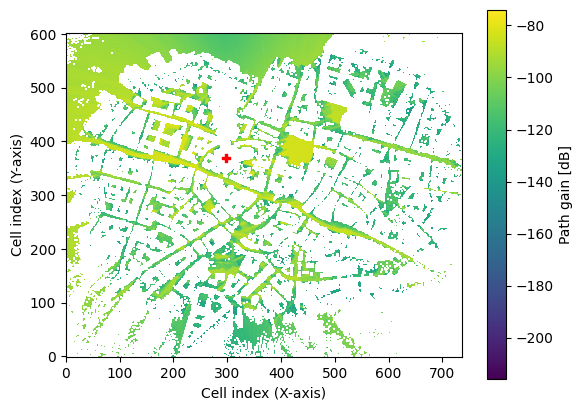

In [5]:
max_depth = 6 # Defines max number of ray interactions
num_rt_samples = int(1e7)

# Update coverage_map
cm = scene.coverage_map(max_depth=max_depth,
                        diffraction=True,
                        scattering=activate_scattering,
                        cm_cell_size=(2., 2.), # 2m x 2m
                        combining_vec=None,
                        precoding_vec=None,
                        num_samples=num_rt_samples)
cm.show();

# coverage map required for sampling of ue positions

### Training and Evaluation Dataset Generation

For the training dataset, we randomly sample 1'000 points from the coverage map that have a non-zero CIR. During training, we construct MU-MIMO channels from the CIR samples. As we simulate up to
2 UEs, we split the training dataset into two partitions of 500 data samples each, to avoid sampling the same data sample twice for the same batch sample. For each training batch sample, we randomly sample one single index
in {0, ..., 499}, which selects the CIR sample indices of both
partitions for both UEs (no random sub-sampling). This avoids an excessive amount of
different UE channel combinations from a given dataset (due to random sub-sampling).

The evaluation dataset is generated from two trajectories
(one for each UE, depicted by the salmon-colored lines in
the figure (far) below), whereof we sample 10'000 positions uniformly between
the starting and end points. Each of the two UEs moves at
a constant speed, 3.5 m/s and 3.0 m/s, respectively. Sample
indices where the ray-tracer did not find any valid path for
either of the two UEs are removed. During simulation,
we construct MU-MIMO channels by randomly sampling two
different indices in {0, ..., 9'999} for each batch sample, which
selects one position for each UE from their respective trajectory. This random sub-sampling approach allows simulating
a significantly increased number of MU-MIMO channel
combinations.

In [12]:
num_samples_train = 1000    # random subsampling increases effective batch_size
num_samples_eval = 10000     # samples on each trajectory

# batch_size for CIR generation (only limited by GPU memory)
batch_size_cir = 100

In [7]:
# define trajectory for evaluation

ue1_waypoints = [[520, 65,1.5], [125, 175,1.5], [90, 30,1.5], [85, 0,1.5], [30, -115,1.5], [110, -175,1.5], [200, -210,1.5], [245, -220,1.5], [400, -285,1.5]]
ue2_waypoints = [[53, 310,1.5], [-72,-91,1.5], [-380,40,1.5], [-485,50,1.5], [-650,95,1.5]]

ue_waypoints = [ue1_waypoints, ue2_waypoints]
ue_speed = [3.5, 3.]

ue_positions = []
ue_velocities = []
traj_lengths = []

# run per user
for wp, speed in zip(ue_waypoints, ue_speed):
    p, v, l = sample_along_trajectory(wp, num_samples_eval, speed)
    ue_positions.append(np.array(p))
    ue_velocities.append(np.array(v))
    traj_lengths.append(l)

The following code visualizes the scene together with the coverage map and the user trajectories. For dynamic 3D rendering of the scene, uncomment the `scene.preview` code line and comment out the `scene.render` code line.

In [8]:
# Add evaluation positions to the scene for visualization
# for r in scene.receivers:
#     scene.remove(r)

for j, ue_pos in enumerate(ue_positions):
    for i, p in enumerate(ue_pos):
        if i % 10 == 0:
            # add only every 10th user to scene for visualization
            rx = Receiver(name=f"rx{j}-{i}",
                        position=p,
                        color=(1.0, 0.5, 0.5)
                        )
            scene.add(rx)

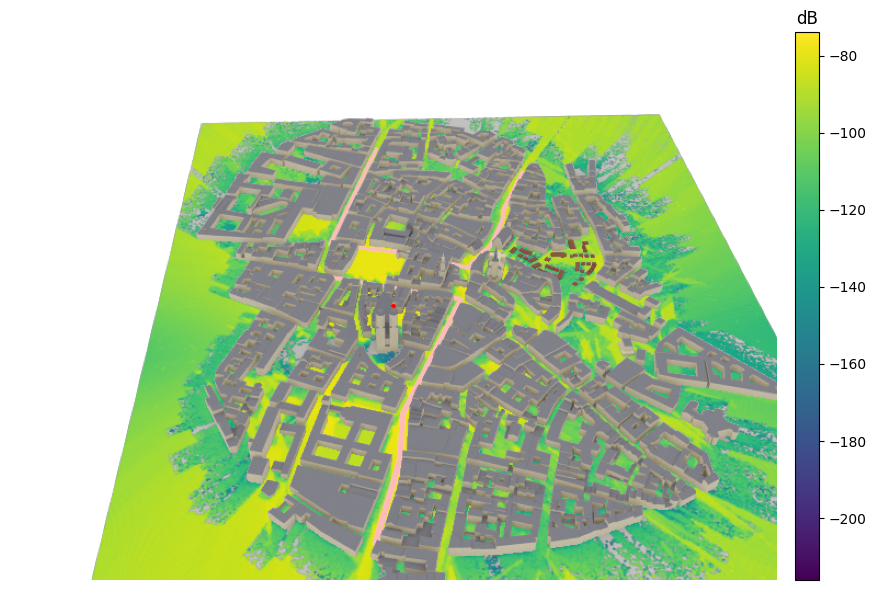

In [9]:
cam = Camera("top-view-eval", position=[-1500., 100.0, 1200.])
scene.add(cam)
cam.look_at(tx.position)
scene.render(camera=cam, resolution=[700,500], coverage_map=cm);

## activate for 3D visualization of scene and UE trajectories
# scene.preview(coverage_map=cm)

In [10]:
def generate_dataset_from_rt(scene, tfrecord_filename, batch_size_cir,
                             ue_positions, ue_velocities, num_paths_cir,
                             ofdm_symbol_duration, num_time_steps, num_samples_to_db=None):
    """
    Generate a dataset from Sionna ray tracer.

    You can specify the number of non-zero CIR samples with num_samples_to_db.
    Otherwise, it samples as many points as defined in ue_positions.
    """

    assert isinstance(ue_positions, list), "ue_positions must be list."
    assert isinstance(ue_velocities, list), "ue_velocities must be list."

    # assume same length for all list entries
    if num_samples_to_db is None:
        # as many sample as position points
        num_samples_to_db = ue_positions[0].shape[0]
        num_samples_to_db_specified = False
    else:
        num_samples_to_db_specified = True

    num_samples = ue_positions[0].shape[0]
    num_batches = int(np.ceil(num_samples/batch_size_cir))
    num_samples_written_to_db = 0
    with tf.io.TFRecordWriter(tfrecord_filename) as writer:
        for p in range(num_batches):
            print(f"Progress: {p/num_batches*100:.1f}%", end="\r")

            a = []
            tau = []
            # can be a list of multiple users
            for ue_idx in range(len(ue_positions)):

                # for evaluation: sample along pre-defined trajectory
                rx_position = ue_positions[ue_idx][
                            p*batch_size_cir:(p+1)*batch_size_cir]
                rx_velocity = ue_velocities[ue_idx][
                            p*batch_size_cir:(p+1)*batch_size_cir]
                # add batch dim
                rx_velocity = tf.expand_dims(rx_velocity, axis=0)

                # update position of receivers
                for i, pos in enumerate(rx_position):
                    scene.get(f"rx-{i}").position = pos

                # run ray tracing
                paths = scene.compute_paths(max_depth=max_depth,
                                            num_samples=num_rt_samples,
                                            diffraction=True,
                                            reflection=True,
                                            scattering=activate_scattering,
                                            scat_keep_prob=0.01,    # reduces memory footprint with scattering
                                            los=True)

                # post-process results
                paths.reverse_direction = True # swap tx/rx direction
                paths.normalize_delays = True # assume synchronized devices
                paths.apply_doppler(sampling_frequency=1/ofdm_symbol_duration,
                                    num_time_steps=num_time_steps,
                                    tx_velocities=rx_velocity)# we have swapped directions

                a_, tau_ = paths.cir(num_paths=num_paths_cir)

                # shape of a [batch_size, num_rx, num_rx_ant, num_tx, num_tx_ant, max_num_paths, num_time_steps]

                # [1, num_rx_ant, num_tx, num_tx_ant, num_paths, num_ofdm_symbols]
                a_ = tf.squeeze(a_, axis=[0])

                # [1, num_rx_ant, 1, batch_size, num_tx_ant, num_paths, num_ofdm_symbols]
                a_ = split_dim(a_, [1, batch_size_cir], axis=2)

                # [batch_size, 1, num_rx_ant, 1, num_tx_ant, num_paths, num_ofdm_symbols]
                a_ = tf.transpose(a_, perm=[3,0,1,2,4,5,6])

                tau_ = tf.squeeze(tau_, axis=0)
                tau_ = split_dim(tau_, [1, batch_size_cir], axis=1)
                tau_ = tf.transpose(tau_, perm=[2, 0, 1, 3])

                a.append(a_)
                tau.append(tau_)

            # a is [batch_size, 1, num_rx_ant, num_tx, num_tx_ant, num_paths, num_ofdm_symbols]
            a = tf.concat(a, axis=3)
            # tau is [batch_size, 1, num_tx, num_paths]
            tau = tf.concat(tau, axis=2)
            # print(a.shape)
            # and export into file
            a_list = tf.unstack(a, axis=0)
            tau_list = tf.unstack(tau, axis=0)

            # serialization seems inefficient, but takes only ~1% of the runtime
            for single_a, single_tau in zip(a_list, tau_list):
                # single_a is [1, num_rx_ant, num_tx, num_tx_ant, num_paths, num_ofdm_symbols]
                # remove entire sample if no path is found across all transmit and receive antennas, for all transmitters and OFDM symbols
                if not tf.reduce_any(tf.reduce_sum(single_a, axis=[0, 1, 3, 4])==0) and num_samples_written_to_db < num_samples_to_db:
                    tf_example = serialize_example(single_a, single_tau)
                    writer.write(tf_example)
                    num_samples_written_to_db += 1

    print("Number of non-zero samples written to TFRecord database: " + str(num_samples_written_to_db))

    # if we specify num_samples_to_db, we must actually also achieve this number of samples
    assert num_samples_written_to_db == num_samples_to_db or not num_samples_to_db_specified, "Specified number of samples not reached"

    # add line break at end of function
    print("\n")

Ray tracing is implemented per UE. For the evaluation dataset, we stack both UEs for each channel dataset sample (simulation batch sample). For the training dataset, we generate 1'000 single-UE CIR samples that are later split into two partitions during training. 

*Remark:* the generated ray tracing CIR dataset is saved to disk as a TFRecord data base. Samples where no paths are found are filtered (not saved to disk). Thus, we sample the coverage map with a safety margin for the training dataset and only store the specified number of non-zero CIR samples to disk. For the evaluation dataset, the actual number of samples is slightly smaller than specified.

In [13]:
num_paths_cir = 48 # max num of paths to be tracked
ue_speed_min = 0 # for training
ue_speed_max = 8 # for training
min_gain_db = -130
max_gain_db = 0
min_dist = 20
max_dist = 700

# remove all old receivers
for r in scene.receivers:
    scene.remove(r)
# and add batch_size new receivers
for i in range(batch_size_cir):
    scene.add(Receiver(f"rx-{i}", [0,0,0], color=(1.0, 0.5, 0.5)))

##################
# Generate dataset
##################

# start with training dataset
print("Generating training dataset")
# train on random positions
fn = f'../data/{sys_parameters.label}_train.tfrecord'

# For training we sample random positions
# We sample more points than necessary in order to assure that we find enough non-zero path samples
num_samples_margin_ceiled = int(np.ceil(1.2*num_samples_train/batch_size_cir)*batch_size_cir)
rx_position = cm.sample_positions(batch_size=num_samples_margin_ceiled,
                                  min_gain_db=min_gain_db,
                                  max_gain_db=max_gain_db,
                                  min_dist=min_dist,
                                  max_dist=max_dist)
# sample random velocity
rx_velocity= np.random.uniform(ue_speed_min, ue_speed_max,
                               (num_samples_margin_ceiled,2))
# no z-velocity in our scenario
rx_velocity = np.concatenate((rx_velocity,
                              np.zeros((num_samples_margin_ceiled,1))), axis=-1)

generate_dataset_from_rt(scene,
                         fn,
                         batch_size_cir,
                         [rx_position,],
                         [rx_velocity,],
                         num_paths_cir=num_paths_cir, # arbitrary
                         ofdm_symbol_duration=ofdm_symbol_duration,
                         num_time_steps=14,
                         num_samples_to_db=num_samples_train)

Generating training dataset
Number of non-zero samples written to TFRecord database: 100




In the following, we illustrate one batch of random UE position samples in the coverage map.

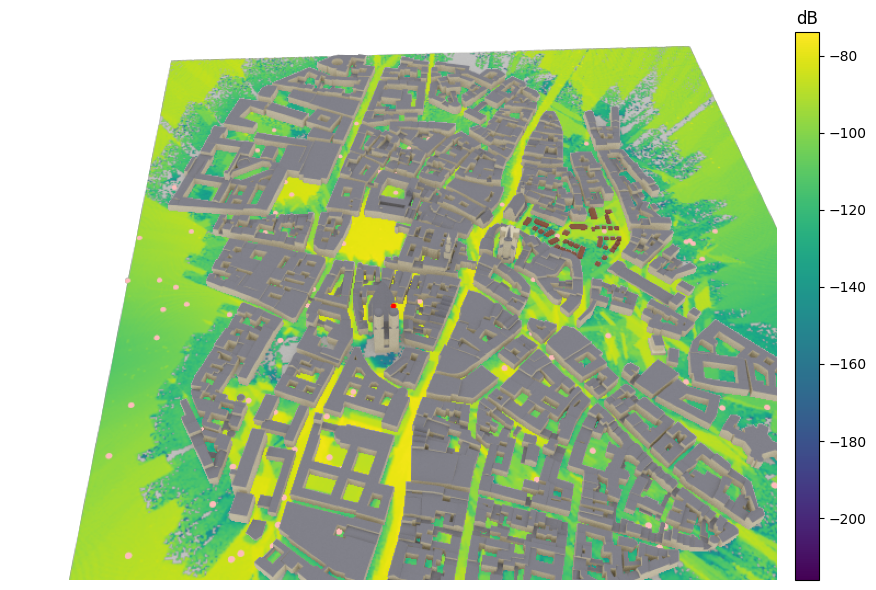

In [15]:
# Visualize last batch of training samples
cam = Camera("top-view-train", position=[-1200., 100.0, 1200.])
scene.add(cam)
cam.look_at(tx.position)
scene.render(camera=cam, resolution=[700,500], coverage_map=cm);

## activate for 3D visualization of scene and UE trajectories
# scene.preview(coverage_map=cm)

In [ ]:
### Generate evaluation dataset along trajectory

print(f"\nGenerating evaluation dataset")
fn = f'../data/{sys_parameters.label}_eval.tfrecord'

generate_dataset_from_rt(scene,
                         fn,
                         batch_size_cir,
                         ue_positions,
                         ue_velocities,
                         num_paths_cir=num_paths_cir, # arbitrary
                         ofdm_symbol_duration=ofdm_symbol_duration,
                         num_time_steps=14)

The dataset is now exported and we can continue with the site-specific fine-tuning training.

## Site-specific Fine-tuning Training

We run the same training and evaluation scripts as before.
The basic procedure is to use a pre-trained generalized NRX (e.g., trained on 3GPP UMI or UMa). In our case, we re-use the same real-time and large NRX architectures as used in the other experiments.

As site-specific training would be done in practice with over-the-air measurement data, perfect channel state information is in practice not available. Hence, our site-specific fine-tuning does not implement the channel estimation loss (i.e., no double-readout).

In the following, we will observe that the RT NRX shows significant performance loss on the ray-tracing dataset. As the Large NRX architecture achieves better generalization than the smaller RT NRX architecture, it also shows much better performance on the ray-tracing dataset than the RT NRX. However, we will show that we can close the performance gap to the generalized Large NRX by site-specific fine-tuning of the RT NRX weights.

In our experiments, we start with the pre-trained NRX RT weights and perform fine-tuning with 1'000 dataset samples (no random sub-sampling). We compare the performance gains between 1'000 and 100'000 fine-tuning training iterations. Note that 1'000 training iterations take about one minute on an NVIDIA RTX 3090, which describes negligible effort for site-specific fine-tuning and can be easily applied during field-deployment of a potential NRX-based 5G NR gNB.

A few remarks regarding training with channel models:
- The collected dataset contains very specific channel realizations from a very
  specific radio environment. It might still happen that not all possible
  scenarios are captured (e.g., a small amount of users with a very high
  velocity). Thus, we believe that pre-training with stochastic models makes the
  system more robust as the synthetic dataset can cover more corner cases.
- We imagine base stations that refine their weights after deployment, i.e., adapt to a specific environment ("controlled overfitting")
- Also in terms of computational resources for training, it appears more
  reasonable to pre-train the NRX once (offline) and fine-tune after deployment
  with only a few thousand training iterations. This avoids that many base
  stations need to learn detection (and decoding) from scratch.
- Note that fine-tuning can lead to catastrophic forgetting, i.e., the fine-tuned NRX will show worse performance on a generalized channel model (e.g., 3GPP UMi) the longer it is fine-tuned


Note that the following commands train the NRX twice, once for 1k iterations, once for 100k iterations. In the paper, we recorded the weights from one single-shot training loop.

In [ ]:
# copy UMi-pretrained weights as initial start
os.system("cp ../weights/nrx_rt_weights ../weights/nrx_site_specific_weights")
os.system("cp ../weights/nrx_rt_weights ../weights/nrx_site_specific_100k_weights")
os.system("cp ../weights/nrx_rt_weights ../weights/nrx_site_specific_baseline_weights")
os.system("cp ../weights/nrx_large_weights ../weights/nrx_site_specific_baseline_large_weights")
os.system("cp ../weights/nrx_large_weights ../weights/nrx_site_specific_large_weights")

# train the nrx for a different number of iterations
os.system("python ../scripts/train_neural_rx.py -config_name nrx_site_specific.cfg -gpu 0")
os.system("python ../scripts/train_neural_rx.py -config_name nrx_site_specific_100k.cfg -gpu 0")
os.system("python ../scripts/train_neural_rx.py -config_name nrx_site_specific_large.cfg -gpu 0")

## BLER Performance Evaluation

After the NRX is trained, we now evaluate the TBLER performance for the above defined trajectory. We compare the fine-tuned neural receiver to various baselines that are not fine-tuned. Note that the baseline NRX as well as the LMMSE channel estimation-based classical receivers are trained on the 3GPP UMi channel model.

Note that both neural receivers are evaluated on the same sytem configuration and the same architecture. However, we load a new configuration file to simplify handling the different NRX weights.

In [ ]:
os.chdir("../scripts/")
os.system("python evaluate.py -config_name nrx_site_specific_baseline.cfg")
os.system("python evaluate.py -config_name nrx_site_specific_baseline_large.cfg -eval_nrx_only")
os.system("python evaluate.py -config_name nrx_site_specific.cfg -eval_nrx_only")
os.system("python evaluate.py -config_name nrx_site_specific_100k.cfg -eval_nrx_only")
os.system("python evaluate.py -config_name nrx_site_specific_large.cfg -eval_nrx_only")

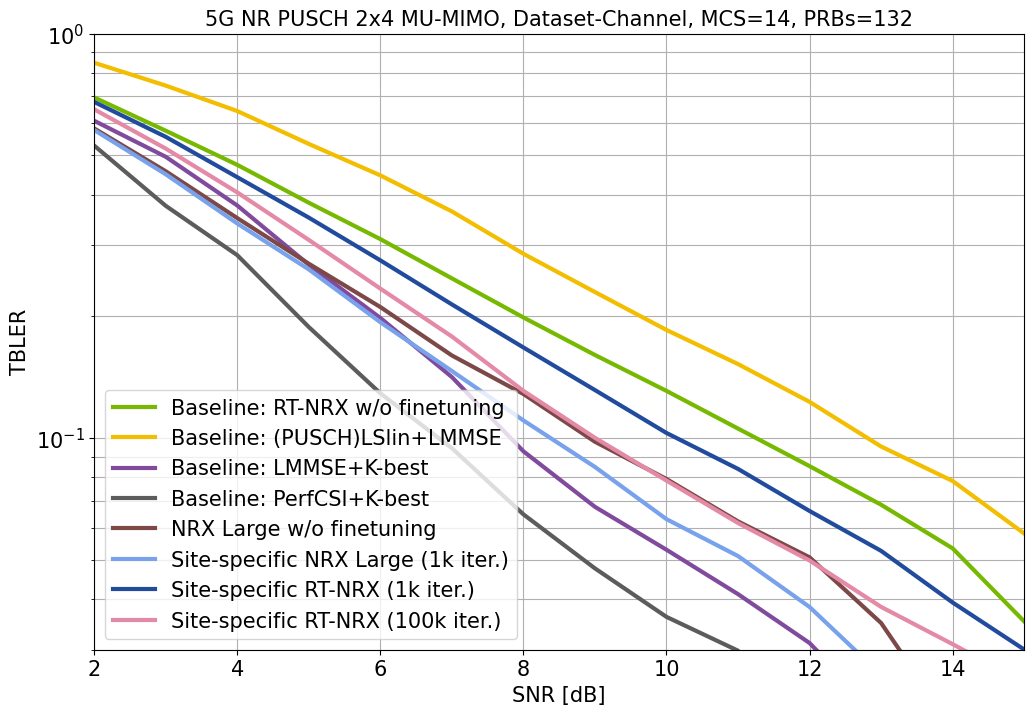

In [16]:
config_name = "nrx_site_specific_baseline.cfg"
num_tx_eval = 2 # depends on what has been evaluated in evaluate.py before

# generate a new figure and plot the 16-QAM baseline results
fig = plot_results(config_name, num_tx_eval=num_tx_eval, xlim=[2,15], ylim=[7e-3,1],
                   labels=["Baseline: RT-NRX w/o finetuning", "Baseline: (PUSCH)LSlin+LMMSE","Baseline: LMMSE+K-best", "Baseline: PerfCSI+K-best"]);

plot_results(fig=fig, config_name="nrx_site_specific_baseline_large.cfg", num_tx_eval=num_tx_eval,
             xlim=[2,15], ylim=[3e-2,1], color_offset=6,
             labels=["NRX Large w/o finetuning"])

plot_results(fig=fig, config_name="nrx_site_specific_large.cfg", num_tx_eval=num_tx_eval,
             xlim=[2,15], ylim=[3e-2,1], color_offset=7,
             labels=["Site-specific NRX Large (1k iter.)"])

plot_results(fig=fig, config_name="nrx_site_specific.cfg", num_tx_eval=num_tx_eval,
             xlim=[2,15], ylim=[3e-2,1], color_offset=4,
             labels=["Site-specific RT-NRX (1k iter.)"])

plot_results(fig=fig, config_name="nrx_site_specific_100k.cfg", num_tx_eval=num_tx_eval,
             xlim=[2,15], ylim=[3e-2,1], color_offset=5,
             labels=["Site-specific RT-NRX (100k iter.)"]);

We observe that with one UE (not illustrated), there are no significant performance gains and all methods perform close to the performance of the LMMSE-K-Best performance.

However, for the dual-user scenario (figure above), we can see significant performance gains through site-specific training.
Reasons for the gains are
- The NRX can inherently learn underlying channel statistics, resulting for example from buildings that are close to the base station
- The NRX is fine-tuned for user behavior (hot spot positions, velocities, etc.)
- Not considered here: the NRX can also be fine-tuned to hardware impairments, e.g., to carrier-frequency-offsets, which can be easily activated in the configuration file

## Effect of Number of Fine-tuning Steps and Data-set Size

We plot the results from our paper that illustrate the effect of the dataset size and number of fine-tuning iterations. The solid lines show the minimal SNR required to achieve a target TBLER of 10% on the evaluation dataset. The dotted lines show the effect of catastrophic forgetting, by evaluating the RT NRX with fine-tuned weights on the 3GPP UMi channel (no normalization and UE velocities of 50 km/h).

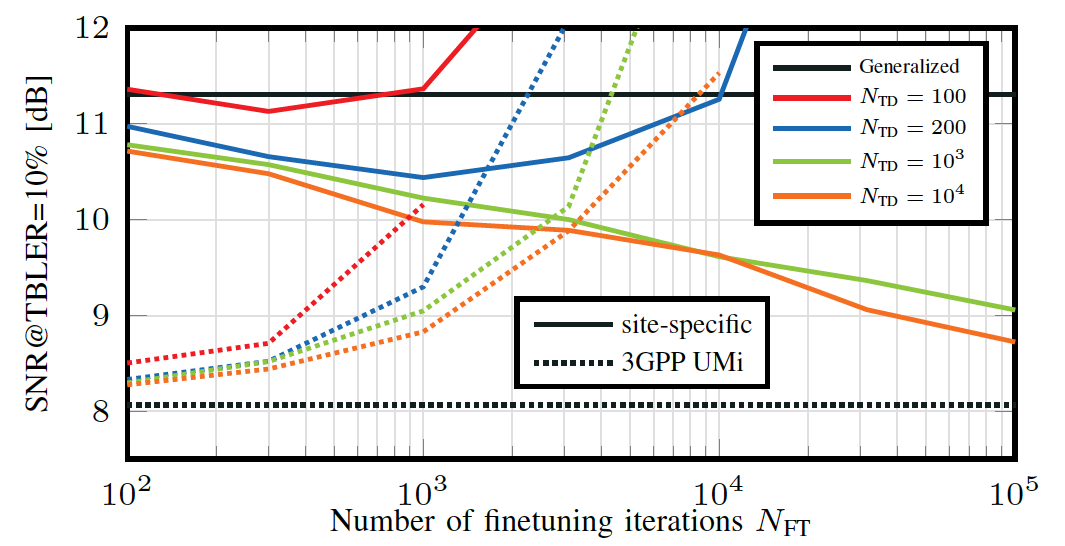

## Outlook

Keep in mind that the computational complexity does not change with fine-tuning. It remains the same receiver algorithm with slightly different weights.

Thus, with the real-time architecture and its extension to variable MCS, the NRX is now ready for deployment. With site-specific fine-tuning before (or shortly after) deployment, we demonstrated to close the performance gap between the generalized Large NRX and the site-specific RT NRX.

We leave for future work to experiment with fine-tuning
on real-world measurement datasets, as well as a system-level performance evaluation. While we expect similar gains
through fine-tuning as with ray-tracing-based channel data, it
remains an open question how much the SNR gains from the
physical layer translate to throughput gains in higher layers.

## References

[1] M. B. Fischer, S. Dörner, S. Cammerer, T. Shimizu, H. Lu, and
S. ten Brink, "[Adaptive neural network-based OFDM receivers](https://arxiv.org/abs/2203.13571)," in 2022
IEEE 23rd International Workshop on Signal Processing Advances in
Wireless Communication (SPAWC). IEEE, 2022, pp. 1–5.

[2] N. Uzlaner, T. Raviv, N. Shlezinger, and K. Todros, "[Asynchronous
online adaptation via modular drift detection for deep receivers](https://arxiv.org/abs/2407.09134)," arXiv
preprint arXiv:2407.09134, Jul. 2024.

[3] J. Hoydis, F. A. Aoudia, S. Cammerer, M. Nimier-David, N. Binder,
G. Marcus, and A. Keller, "[Sionna RT: Differentiable ray tracing
for radio propagation modeling](https://arxiv.org/abs/2303.11103)," in 2023 IEEE Globecom Workshops.
IEEE, Mar. 2023, pp. 317–321.